In [116]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import warnings
import networkx as nx
import matplotlib.colors as mcolors
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import naive_greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
import networkx.algorithms.community as nx_comm
from networkx.algorithms.connectivity.edge_kcomponents import bridge_components
import glob 
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.readwrite import json_graph
import json
from itertools import islice
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.ticker as tk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier 
import torch 
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import GraphicalLassoCV
from networkx.generators.community import gaussian_random_partition_graph
import scipy.stats as stats
from scipy.stats import ttest_ind
import nibabel as nib 

In [29]:
#start with formattting data, getting master csv of all patients regional volume 
#create master csv file with all vol for each region for eahc patient
#cols would be 'id','001','002'....
#rows would be id numbers 0173

dir = "/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi"
data_dic = {}
patient_data = {}
#iterate through patient folders to extract the values of the .npy files 
for folder in sorted(glob.glob(os.path.join(dir,"wneuromorphometrics_*"))):
    # print(f"processing: {folder}")
    id = folder[-4:]
    volumes = []
    #data dicitonary to store corresponding labels and values 
    for file in sorted(glob.glob(os.path.join(folder, "*.npy"))): #search for all .npy files 
        reg_num = os.path.splitext(os.path.basename(file))[0] #os.path.basename returns filename itself with extension
        #os.path.splittext()[0] splits file basename into a tuple of file name string and the extension (001,.npy) [0] tells it to extract first el of this tuple (001)
        # print(reg_num)
        node_data = np.load(file)
        # print(reg_num, node_data)
        data_dic[reg_num]=node_data
        volumes.append(node_data)

    patient_data[id]=volumes

patient_ids = list(patient_data.keys())

progs_norm = pd.DataFrame.from_dict(patient_data,orient='index')
progs_norm.columns = [str(int(col) + 1) for col in progs_norm.columns]
progs_norm['id'] = patient_ids
progs_norm.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/mega_csv.csv')
print(progs_norm.shape)
print(progs_norm)

(545, 143)
            1    2    3    4    5    6    7    8     9    10  ...    134  \
0173  1461786  118  285  303  150  150  350  352  5258  6796  ...  11021   
0307  1460313  117  285  302  149  154  347  354  5277  6769  ...  11041   
0331  1459847  119  285  303  147  153  349  354  5277  6786  ...  11009   
0376  1461197  120  284  302  149  138  349  354  5261  6758  ...  11035   
0388  1462081  121  285  302  149  151  348  355  5289  6766  ...  11023   
...       ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...    ...   
6627  1461387  117  285  303  149  154  349  355  5272  6797  ...  10983   
6632  1459008  119  285  302  152  155  350  355  5279  6850  ...  11093   
6635  1456677  111  275  300  148  153  349  347  5283  6838  ...  11038   
6652  1458206  119  283  301  151  152  352  354  5274  6808  ...  11087   
6668  1458654  115  282  301  147  153  351  352  5303  6825  ...  11062   

       135   136   137   138   139   140   141   142    id  
0173  5701  635

In [30]:
#add in progression info and then split dataframes into stable and progressive mci 

prog_info = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/ADNI_surv_prog.csv")
# all_df = pd.read_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/hip_weights.csv") #doesn't work if I just read it in as a csv weird 

prog = prog_info[['RID',"PROGRESSES"]]
#add in padded zeros to prog df 
prog['RID']=prog["RID"].astype(str).str.zfill(4)

#filter prog to only include ids we want 
prog = prog[prog["RID"].isin(progs_norm['id'].astype(str))]
print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()[1]}\nN Stable MCI={(545-154)}")  #in entire dataset, only 154 who progress 

#merge all_df df and prog df on index RID and ID
merged = prog.merge(progs_norm,left_on='RID', right_on='id')

merged = merged.drop('id',axis=1) #drop id along col axis 

N Progressive MCI=154
N Stable MCI=391


/tmp/ipykernel_3271916/1048783910.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog['RID']=prog["RID"].astype(str).str.zfill(4)


In [31]:
#separate dfs for progressors and stable 
#creat empty dfs 
progs = pd.DataFrame()
stable = pd.DataFrame()

for index,row in merged.iterrows():
    if row['PROGRESSES']==1:
        progs = progs.append(row)
    else:
        stable = stable.append(row)

print(progs)
print(stable)

progs.to_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/progressors_vol.csv")
stable.to_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/stable_vol.csv")

      RID  PROGRESSES        1    2    3    4    5    6    7    8  ...    133  \
2    0331         1.0  1459847  119  285  303  147  153  349  354  ...  11197   
3    0376         1.0  1461197  120  284  302  149  138  349  354  ...  11205   
4    0388         1.0  1462081  121  285  302  149  151  348  355  ...  11225   
7    0423         1.0  1461269  122  284  302  150  152  352  351  ...  11261   
8    0429         1.0  1462322  122  285  303  151  154  348  356  ...  11184   
..    ...         ...      ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
467  4974         1.0  1461260  119  285  303  149  150  349  354  ...  11260   
476  5026         1.0  1459352  119  284  303  151  154  348  353  ...  11251   
484  5285         1.0  1461867  120  286  301  150  150  344  357  ...  11225   
502  6252         1.0  1459859  119  281  303  150  154  350  352  ...  11277   
514  6345         1.0  1461470  122  283  302  149  153  349  356  ...  11281   

       134   135   136   13

In [32]:
#drop rows for ventricles, chaism, csf, and background 
#drop 1,2,3,4,23,24,25,26,35,36

progs_d = progs.drop(['1','2','3','4','19','20','23','24','25','26','35','36'], axis =1)
stable = stable.drop(['1','2','3','4','19','20','23','24','25','26','35','36'], axis =1)

progs.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/ADNI_pruned_prog_csv.csv')
stable.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/ADNI_pruned_stable_csv.csv')

In [33]:
#for the correlation matrix need to only have the values 
progs_dd = progs_d.drop(["RID","PROGRESSES"], axis =1)
stable = stable.drop(["RID","PROGRESSES"], axis =1)

In [34]:
#convert to float
progs_f = progs_dd.astype(float)
stable = stable.astype(float)
print(stable)

         5      6      7      8       9      10      11      12       13  \
0    150.0  150.0  350.0  352.0  5258.0  6796.0  1169.0  1277.0  32094.0   
1    149.0  154.0  347.0  354.0  5277.0  6769.0  1169.0  1285.0  32187.0   
5    150.0  153.0  350.0  350.0  5269.0  6813.0  1174.0  1275.0  32176.0   
6    150.0  153.0  347.0  355.0  5258.0  6757.0  1172.0  1280.0  32014.0   
11   146.0  152.0  352.0  360.0  5281.0  6845.0  1174.0  1282.0  32313.0   
..     ...    ...    ...    ...     ...     ...     ...     ...      ...   
539  149.0  154.0  349.0  355.0  5272.0  6797.0  1175.0  1281.0  32135.0   
540  152.0  155.0  350.0  355.0  5279.0  6850.0  1167.0  1274.0  32461.0   
541  148.0  153.0  349.0  347.0  5283.0  6838.0  1173.0  1279.0  32506.0   
542  151.0  152.0  352.0  354.0  5274.0  6808.0  1174.0  1275.0  32399.0   
543  147.0  153.0  351.0  352.0  5303.0  6825.0  1169.0  1282.0  32348.0   

          14  ...      133      134     135     136     137     138     139  \
0    324

In [35]:
#normalize with z score, negative values are fine it means its an std below mean 
progs_norm = (progs_f - progs_f.mean()) / progs_f.std()
stable_norm = (stable - stable.mean()) / stable.std()
print(progs_norm)

            5         6         7         8         9        10        11  \
2   -1.305644  0.322746  0.227475 -0.121612 -0.013293 -0.469851  0.971008   
3   -0.376918 -5.942324  0.227475 -0.121612 -1.142755 -1.466406 -0.264820   
4   -0.376918 -0.512597 -0.252404  0.268559  0.833803 -1.181676 -0.264820   
7    0.087445 -0.094925  1.667114 -1.292123 -1.001572  0.348748  0.662051   
8    0.551808  0.740417 -0.252404  0.658729 -1.848668 -0.363077  0.353094   
..        ...       ...       ...       ...       ...       ...       ...   
467 -0.376918 -0.930268  0.227475 -0.121612 -1.213346 -1.644362 -0.573778   
476  0.551808  0.740417 -0.252404 -0.511782  0.622029 -0.718989 -1.191692   
484  0.087445 -0.930268 -2.171922  1.048900 -0.789798 -1.003719  0.353094   
502  0.087445  0.740417  0.707355 -0.901952  0.339664  0.455522  0.971008   
514 -0.376918  0.322746  0.227475  0.658729 -0.366250 -1.146084  0.353094   

           12        13        14  ...       133       134       135  \
2  

In [37]:
#NEEDS TO BE 154x130 format for model
progs_norm = progs_norm.T
print(progs_norm)

            5         6         7         8         9        10        11  \
2   -1.305644  0.322746  0.227475 -0.121612 -0.013293 -0.469851  0.971008   
3   -0.376918 -5.942324  0.227475 -0.121612 -1.142755 -1.466406 -0.264820   
4   -0.376918 -0.512597 -0.252404  0.268559  0.833803 -1.181676 -0.264820   
7    0.087445 -0.094925  1.667114 -1.292123 -1.001572  0.348748  0.662051   
8    0.551808  0.740417 -0.252404  0.658729 -1.848668 -0.363077  0.353094   
..        ...       ...       ...       ...       ...       ...       ...   
467 -0.376918 -0.930268  0.227475 -0.121612 -1.213346 -1.644362 -0.573778   
476  0.551808  0.740417 -0.252404 -0.511782  0.622029 -0.718989 -1.191692   
484  0.087445 -0.930268 -2.171922  1.048900 -0.789798 -1.003719  0.353094   
502  0.087445  0.740417  0.707355 -0.901952  0.339664  0.455522  0.971008   
514 -0.376918  0.322746  0.227475  0.658729 -0.366250 -1.146084  0.353094   

           12        13        14  ...       133       134       135  \
2  

In [120]:
#graphical lasso 
#estimates the precision matrix of the data (inverse cov mat which models the partial correlations between vars)
#uses lasso penalty, during training the model iteratively updates the estimated precision matrix using current hyperparamter values until it converges to a set of values that minimize the loss function 
model = GraphicalLassoCV(cv=5) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
model.fit(progs_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5)

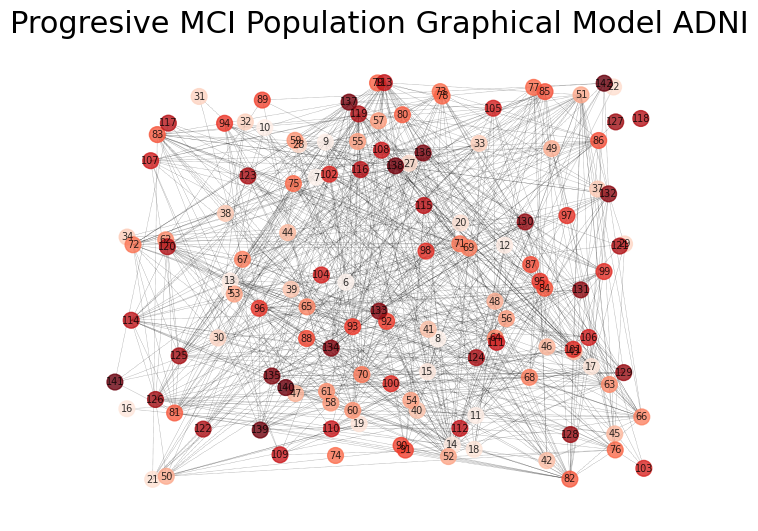

In [122]:
#represents conditional independence structure of data, strength and direction of a relationship between 
#this graph has learned and pruned the weaker connections in the precision matrix
#graph represents the strongest and most important connections between the brain volume 

precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_prog = nx.Graph(precision_matrix_p)
# Create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(progs_norm.columns)}

# Relabel the nodes in the graph using the dictionary
G_prog = nx.relabel_nodes(G_prog, node_labels)

# Visualize the relabeled graph
pos = nx.random_layout(G_prog)
nx.draw(G_prog, pos, with_labels=True, font_size=7, style="dotted",
        node_color=range(len(G_prog)), cmap=plt.cm.Reds,
        node_size=150*len(G_prog)/154, alpha=.8, width=.3)
plt.title("Progresive MCI Population Graphical Model ADNI", fontsize=22)
plt.show()

In [41]:
#strongest edges sorteed 

edges_sorted = sorted(G_prog.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(int(edge[0]), int(edge[1]), edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(18, 78, {'weight': 0.265287058722154})
(39, 66, {'weight': 0.21076456458218498})
(17, 29, {'weight': 0.20689720461596908})
(18, 30, {'weight': 0.19507026389440646})
(18, 28, {'weight': 0.18189769608126097})
(18, 48, {'weight': 0.16901224609150184})
(12, 18, {'weight': 0.15891263980248355})
(17, 77, {'weight': 0.13193825494142825})
(17, 27, {'weight': 0.1287118018191243})
(18, 110, {'weight': 0.12369262966687461})


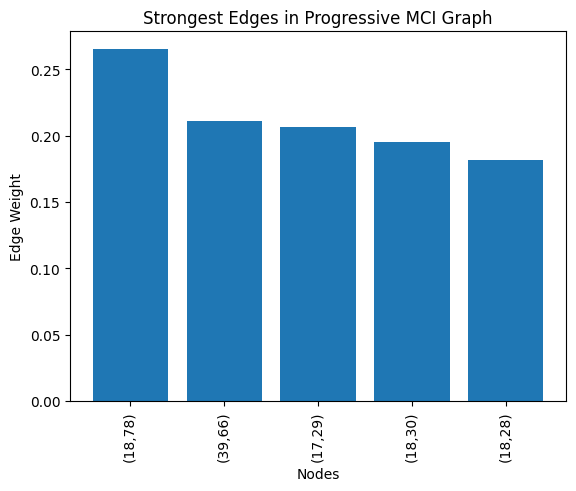

In [42]:
#plot 
top_edges = edges_sorted_shifted[:5]


x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Progressive MCI Graph')
plt.show()

In [46]:
#stable 
stable_norm = stable_norm.T
print(stable_norm.shape)  #shape needs to be 390 x 140 patients x regions 

(390, 130)


In [123]:
#fit for stable norm df 
stab_model = GraphicalLassoCV(cv=5)
stab_model.fit(stable_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 9.153e-04
  warnings.warn(


GraphicalLassoCV(cv=5)

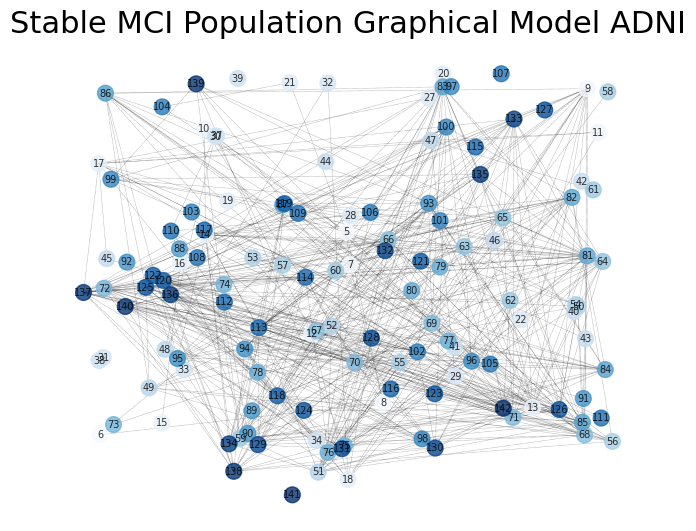

In [124]:
precision_matrix_s = stab_model.precision_
np.fill_diagonal(precision_matrix_s, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_stab = nx.Graph(precision_matrix_s)
# Create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(stable_norm.columns)}

# Relabel the nodes in the graph using the dictionary
G_stab = nx.relabel_nodes(G_stab, node_labels)

# Visualize the relabeled graph
pos = nx.random_layout(G_stab)
nx.draw(G_stab, pos, with_labels=True, font_size=7, style="dotted",
        node_color=range(len(G_prog)), cmap=plt.cm.Blues,
        node_size=150*len(G_prog)/154, alpha=.8, width=.3)
plt.title("Stable MCI Population Graphical Model ADNI", fontsize=22)
plt.show()

In [49]:
edges_sorted = sorted(G_stab.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(int(edge[0]), int(edge[1]), edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(18, 78, {'weight': 0.27783956633253576})
(17, 77, {'weight': 0.2586528197553451})
(17, 29, {'weight': 0.21298144204037386})
(17, 103, {'weight': 0.16973816862326385})
(17, 27, {'weight': 0.15968144723422525})
(18, 30, {'weight': 0.1437351771043876})
(17, 28, {'weight': 0.13042776487967941})
(17, 47, {'weight': 0.12334081201739118})
(18, 48, {'weight': 0.1228802172175597})
(18, 46, {'weight': 0.1227428875966686})


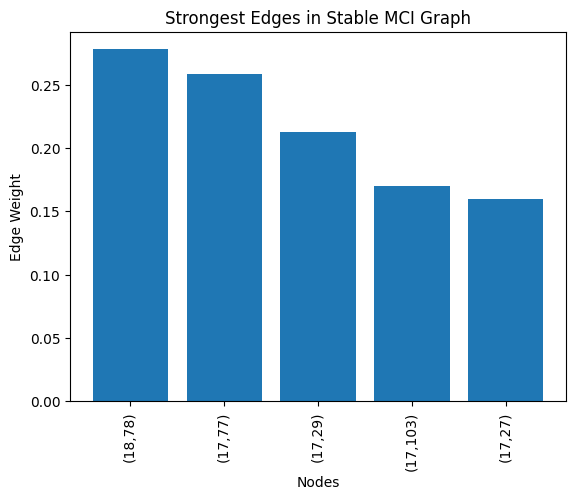

In [50]:
#plot 
top_edges = edges_sorted_shifted[:5]

x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Stable MCI Graph')
plt.show()

In [51]:
##compare graph metrics for andi 

#modularity 
mod_p = nx.algorithms.community.modularity(G_prog, nx.algorithms.community.greedy_modularity_communities(G_prog))
print("Prog Modularity:", mod_p)
mod_s = nx.algorithms.community.modularity(G_stab, nx.algorithms.community.greedy_modularity_communities(G_stab))
print("Stable Modularity:", mod_s)

#global path effiency 
ge_p = nx.global_efficiency(G_prog)
print("\nProg Global efficiency:", ge_p)
ge_s = nx.global_efficiency(G_stab)
print("Stable Global efficiency:", ge_s)

#clustering coefficient 
cl_p = nx.average_clustering(G_prog)
print(f"\nProg Clustering Coeff:",cl_p)
cl_s = nx.average_clustering(G_stab)
print(f"Stable Clustering Coeff",cl_s)

Prog Modularity: 0.16637856073863297
Stable Modularity: 0.2699519061214879

Prog Global efficiency: 0.4212343470482634
Stable Global efficiency: 0.2996998608626528

Prog Clustering Coeff: 0.24890969775265448
Stable Clustering Coeff 0.28867990738129456


In [55]:
#NACC
dir = "/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi"
data_dic = {}
patient_data = {}
#iterate through patient folders to extract the values of the .npy files 
#need touble check this by printing id because NACC folders have naming convention NACC[0-9][0-9][0-9][0-9][0-9][0-9]
for folder in sorted(glob.glob(os.path.join(dir,"NACC*"))):
    # print(f"processing: {folder}")
    id = folder[-6:]

    # print(id)
    volumes = []
    #data dicitonary to store corresponding labels and values 
    for file in sorted(glob.glob(os.path.join(folder, "*.npy"))): #search for all .npy files 
        reg_num = os.path.splitext(os.path.basename(file))[0] #os.path.basename returns filename itself with extension
        #os.path.splittext()[0] splits file basename into a tuple of file name string and the extension (001,.npy) [0] tells it to extract first el of this tuple (001)
        # print(reg_num)
        node_data = np.load(file)
        # print(reg_num, node_data)
        data_dic[reg_num]=node_data
        volumes.append(node_data)

    patient_data[id]=volumes

patient_ids = list(patient_data.keys())

df = pd.DataFrame.from_dict(patient_data,orient='index')
df.columns = [str(int(col) + 1) for col in df.columns]
df['RID'] = patient_ids
#only pad ids that are not already 6 digits 
df['RID']=df['RID'].apply(lambda x: f"NACC{x:0>6}")
#make rid col the index (first col)
df = df.set_index('RID').reset_index()


#adding a weird last row to the df with empty values so drop is 
df = df.drop(df.index[-1],axis=0)
#save
df.to_csv('/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/mega_NACC.csv')


In [63]:
#add in progression info and then split dataframes into stable and progressive mci 
#find nacc prog info 

prog_info = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/NACC_surv_prog.csv")
# all_df = pd.read_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/hip_weights.csv") #doesn't work if I just read it in as a csv weird 

prog = prog_info[['RID',"PROGRESSES"]]
#add in padded zeros to prog df 
prog['RID']=prog["RID"].astype(str).str.zfill(4)

prog = prog[prog["RID"].isin(df['RID'].astype(str))]

prog=prog.reset_index(drop=True)
prog_num = len(prog[prog['PROGRESSES']==1].value_counts()) #130 progress 
# print(prog_num)
# print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()[1]}\nN Stable MCI={(545-154)}")  #in entire dataset, only 154 who progress 
print(f"N Progressive MCI={prog_num}\n N Stable MCI={508-prog_num}")

#merge all_df df and prog df on index RID and ID
merged = pd.merge(prog,df,on='RID')


N Progressive MCI=130
 N Stable MCI=378


/tmp/ipykernel_3271916/2395053916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog['RID']=prog["RID"].astype(str).str.zfill(4)


In [64]:
#separate dfs for progressors and stable 
#creat empty dfs 
progs = pd.DataFrame()
stable = pd.DataFrame()

for index,row in merged.iterrows():
    if row['PROGRESSES']==1:
        progs = progs.append(row)
    else:
        stable = stable.append(row)

# print(progs)
# print(stable)

progs.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_vol.csv")
stable.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_vol.csv")

In [65]:
#drop row 23 and 25 because they are ventricle and chiasm and have no volume 
# zero_col = df.columns[(df ==0).any()]
# print(zero_col)

#drop 1,2,3,4,23,24,25,26,35,36

progs = progs.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)
stable = stable.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)

#drop all the ventricles and region 001 because its the background and not the data we need 
#in this the bacground region 0 and region 1 are both combined in region 1 
progs.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_pruned_vol.csv")
stable.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_pruned_vol.csv")

In [66]:
#for the correlation matrix need to only have the values 
progs = progs.drop(["RID","PROGRESSES"], axis =1)
stable = stable.drop(["RID","PROGRESSES"], axis =1)

#convert to float
progs = progs.astype(float)
stable = stable.astype(float)
# print(stable)

In [69]:
#normalize with z score, negative values are fine it means its an std below mean 
progs_norm = (progs - progs.mean()) / progs.std()
stable_norm = (stable - stable.mean()) / stable.std()
# print(progs_norm)

In [73]:
#NEEDS TO BE 130x 132 format for model  (32 brain regions left)
progs_norm = progs_norm.T
print(progs_norm.shape)

(130, 132)


In [125]:
model = GraphicalLassoCV(cv=5) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
model.fit(progs_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5)

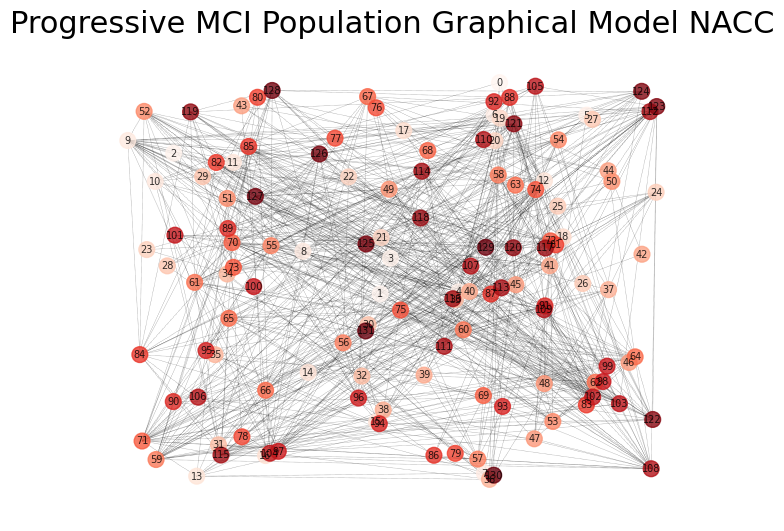

In [126]:
#graph 
precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0)
G_prog = nx.Graph(precision_matrix_p)
pos = nx.random_layout(G_prog)
nx.draw(G_prog, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_p)),
        cmap=plt.cm.Reds, node_size=150*len(precision_matrix_p)/154, alpha=.8, width=.3)
#size inconsistent and makes me enter 
plt.title("Progressive MCI Population Graphical Model NACC", fontsize=22)
plt.show()

In [76]:
#strongest edges 
edges_sorted = sorted(G_prog.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(8, 14, {'weight': 0.8081280916439814})
(14, 52, {'weight': 0.5846940558012397})
(8, 22, {'weight': 0.5420483736426855})
(14, 38, {'weight': 0.3971330780432793})
(22, 52, {'weight': 0.26123246493864094})
(13, 21, {'weight': 0.25501459715961994})
(13, 67, {'weight': 0.24904302557367547})
(46, 102, {'weight': 0.23550528347468172})
(22, 46, {'weight': 0.2040683771810523})
(13, 19, {'weight': 0.18903509139145883})


In [78]:
#stable model and graph 
#NEEDS TO BE 378x 132 format for model  (32 brain regions left)
stable_norm = stable_norm.T
print(stable_norm.shape)

(378, 132)


In [127]:
#stable model 
#fit for stable norm df 
stab_model = GraphicalLassoCV(cv=5)
stab_model.fit(stable_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 9.153e-04
  warnings.warn(


GraphicalLassoCV(cv=5)

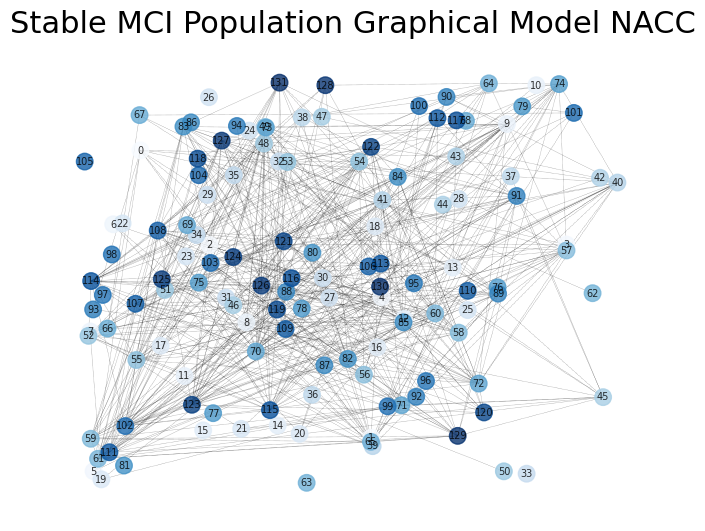

In [128]:
#stable graph 
precision_matrix_s = stab_model.precision_
np.fill_diagonal(precision_matrix_s, 0)
G_stab = nx.Graph(precision_matrix_s)
pos = nx.random_layout(G_stab)
nx.draw(G_stab, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_s)),
        cmap=plt.cm.Blues, node_size=150*len(precision_matrix_s)/140, alpha=.8, width=.3)
plt.title("Stable MCI Population Graphical Model NACC", fontsize=22)
plt.show()

In [81]:
#top 10 strongest edges in stable 
edges_sorted = sorted(G_stab.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(8, 22, {'weight': 0.6654628847341104})
(8, 100, {'weight': 0.590366683206648})
(13, 21, {'weight': 0.3298110262672875})
(46, 100, {'weight': 0.26497414450752155})
(8, 14, {'weight': 0.2558890942096627})
(14, 68, {'weight': 0.24919727692235774})
(13, 67, {'weight': 0.20745862879657145})
(14, 38, {'weight': 0.12752115284126436})
(22, 46, {'weight': 0.12064692506015218})
(7, 13, {'weight': 0.12007050173735036})


In [82]:
#compare graph metrics 

#modularity 
mod_p_n = nx.algorithms.community.modularity(G_prog, nx.algorithms.community.greedy_modularity_communities(G_prog))
print("Prog Modularity:", mod_p_n)
mod_s_n = nx.algorithms.community.modularity(G_stab, nx.algorithms.community.greedy_modularity_communities(G_stab))
print("Stable Modularity:", mod_s_n)

#global path effiency 
ge_p_n = nx.global_efficiency(G_prog)
print("\nProg Global efficiency:", ge_p_n)
ge_s_n = nx.global_efficiency(G_stab)
print("Stable Global efficiency:", ge_s_n)

#clustering coefficient 
cl_p_n = nx.average_clustering(G_prog)
print(f"\nProg Clustering Coeff:",cl_p_n)
cl_s_n = nx.average_clustering(G_stab)
print(f"Stable Clustering Coeff",cl_s_n)

Prog Modularity: 0.22721855141293468
Stable Modularity: 0.4517573412616496

Prog Global efficiency: 0.41277662117353375
Stable Global efficiency: 0.22132970930681148

Prog Clustering Coeff: 0.2832195453170149
Stable Clustering Coeff 0.4227596075337266


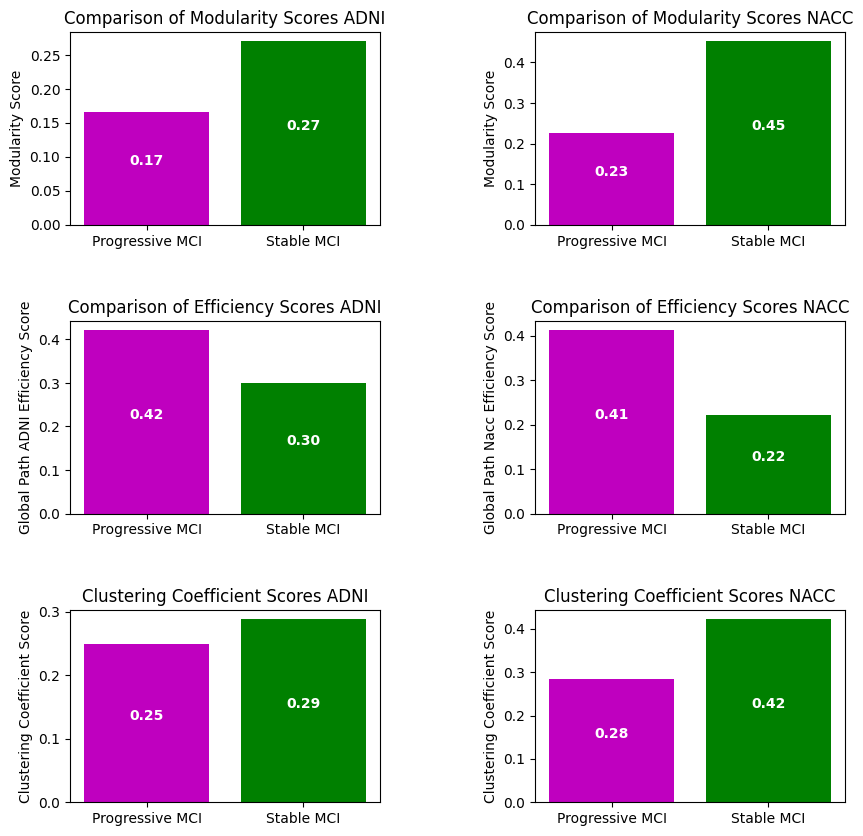

In [115]:
#plot ADNI and NACC together 
colors = ['m','green']
#ADNI 
# Define the data for the three bar plots
m_scores = [mod_p, mod_s]
g_scores = [ge_p, ge_s]
c_scores = [cl_p, cl_s]


#NACC 
# Define the data for the three bar plots
m_scores_n = [mod_p_n, mod_s_n]
g_scores_n = [ge_p_n, ge_s_n]
c_scores_n = [cl_p_n, cl_s_n]

labels = ["Progressive MCI", "Stable MCI"]

# Create a figure with 6 subplots, 2 for each barplot 
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
#add space vetween pots 
plt.subplots_adjust(hspace=.5)

# define function to add text inside bars
def add_text_inside_bar(rects, axs):
    for rect in rects:
        height = rect.get_height()
        axs.text(rect.get_x() + rect.get_width() / 2., height / 2., f"{height:.2f}",
                 ha='center', va='bottom', color='white', fontweight='bold')

# first subplot m score adni 
rects1=axs[0,0].bar(labels,m_scores,color=colors)
axs[0,0].set_ylabel("Modularity Score")
axs[0,0].set_title("Comparison of Modularity Scores ADNI")
add_text_inside_bar(rects1,axs[0,0])


#secon d subplot nacc m 
rects2 = axs[0,1].bar(labels, m_scores_n, color = colors)
axs[0,1].set_ylabel("Modularity Score")
axs[0,1].set_title("Comparison of Modularity Scores NACC")
add_text_inside_bar(rects2,axs[0,1])


# third subplot adni g 
rects3 = axs[1,0].bar(labels, g_scores, color = colors)
axs[1,0].set_ylabel("Global Path ADNI Efficiency Score")
axs[1,0].set_title("Comparison of Efficiency Scores ADNI")
add_text_inside_bar(rects3,axs[1,0])

#fourth subplot nacc g 
rects4 = axs[1,1].bar(labels, g_scores_n, color = colors)
axs[1,1].set_ylabel("Global Path Nacc Efficiency Score")
axs[1,1].set_title("Comparison of Efficiency Scores NACC")
add_text_inside_bar(rects4,axs[1,1])

#fifth subplot adni c 
rects5 = axs[2,0].bar(labels, c_scores, color = colors)
axs[2,0].set_ylabel("Clustering Coefficient Score")
axs[2,0].set_title("Clustering Coefficient Scores ADNI")
add_text_inside_bar(rects5,axs[2,0])

#sixth subplot nacc c 
rects6 = axs[2,1].bar(labels, c_scores_n, color = colors)
axs[2,1].set_ylabel("Clustering Coefficient Score")
axs[2,1].set_title("Clustering Coefficient Scores NACC")
add_text_inside_bar(rects6,axs[2,1])

# Adjust the spacing between subplots and display the figure
plt.subplots_adjust(wspace=0.5)
plt.show()

In [119]:
#significance tests 
all_mod_p = [mod_p,mod_p_n]
all_mod_s = [mod_s, mod_s_n]

all_c_p = [cl_p,cl_p_n]
all_c_s = [cl_s,cl_s_n]

all_g_p = [ge_p,ge_p_n]
all_g_s = [ge_s,ge_s_n]


t_stat,p_val = stats.ttest_ind(all_mod_p,all_mod_s)
print('t-stat: {:.3f}'.format(t_stat))
print("pval: {:.3f}".format(p_val))



t-stat: -1.711
pval: 0.229
